# Running Multiple Circuits on Hardware

This tutorial shows how a quantum circuit can be run on actual quantum hardware.

## Import all Necessary Libraries

In [1]:
from NoisyCircuits.QuantumCircuit import QuantumCircuit as nqc
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
from NoisyCircuits.RunOnHardware import RunOnHardware
import os
import numpy as np
import json
import matplotlib.pyplot as plt

2025-11-24 17:25:50,694	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Define all Necessary Parameters

In [ ]:
token = json.load(open(os.path.join(os.path.expanduser("~"), "ibm_api.json"), "r"))["apikey"] # Replace with your IBM Quantum API token
backend_name = "ibm_fez"
shots = 2048
verbose = False
jsonize = True
num_qubits = 2
num_trajectories = 500
qpu = "heron" # Only possible option for IBM backends at the moment
num_cores = 50
sim_backend = "pennylane" # Choose between "pennylane", "qulacs" and "qiskit"

## Get the Noise Model

In [3]:
noise_model = GetNoiseModel(
    token=token,
    backend_name=backend_name
).get_noise_model()

qiskit_runtime_service._discover_account:WARNING:2025-11-24 17:25:55,510: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-24 17:25:58,542: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-24 17:25:58,544: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-24 17:25:58,931: Using instance: Open_Sys, plan: open


## Build all Quantum Circuits

In [ ]:
circuit = nqc(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores,
         backend_qpu_type=qpu, 
         num_trajectories=num_trajectories, 
         sim_backend=sim_backend,
         jsonize=jsonize,
         verbose=verbose)

# List to store all probabilities from Pure State Simulation
probs_pure_list = []
# List to store all probabilities from MCWF Simulations
probs_sim_list = []

2025-11-24 17:26:12,833	INFO worker.py:2012 -- Started a local Ray instance.
/Users/adam-ukj7r05xnu2fywx/miniconda3/envs/NoisyCircuits_New_Branch/lib/python3.10/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [5]:
hardware_runner = RunOnHardware(
    token=token,
    backend=backend_name,
    shots=shots
)

qiskit_runtime_service._discover_account:WARNING:2025-11-24 17:26:16,285: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-24 17:26:20,072: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Open_Sys. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-24 17:26:20,075: Loading instance: Open_Sys, plan: open


## Circuit 1: SWAP States

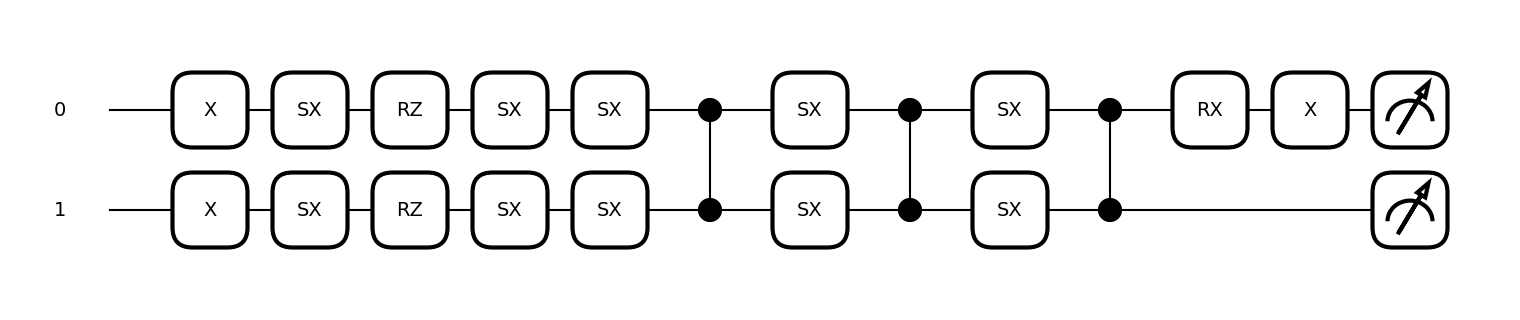

In [6]:
circuit.RY(1.4, 0)
circuit.RY(2.5, 1)
circuit.SWAP(0, 1)
circuit.draw_circuit(style="mpl")

In [7]:
hardware_runner.create_circuits(
    circuit=circuit,
    measure_qubits=list(range(num_qubits))
)

In [ ]:
probs_pure_list.append(circuit.run_pure_state(list(range(num_qubits))))
probs_sim_list.append(circuit.execute(list(range(num_qubits))))

[2025-11-24 17:26:43,519 E 723289 723652] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


## Circuit 2: Parameterized Circuit

Set up a parameterized circuit with different set of parameters

In [10]:
parameter_set = [np.random.uniform(-2*np.pi, 2*np.pi, size=8) for _ in range(2)]

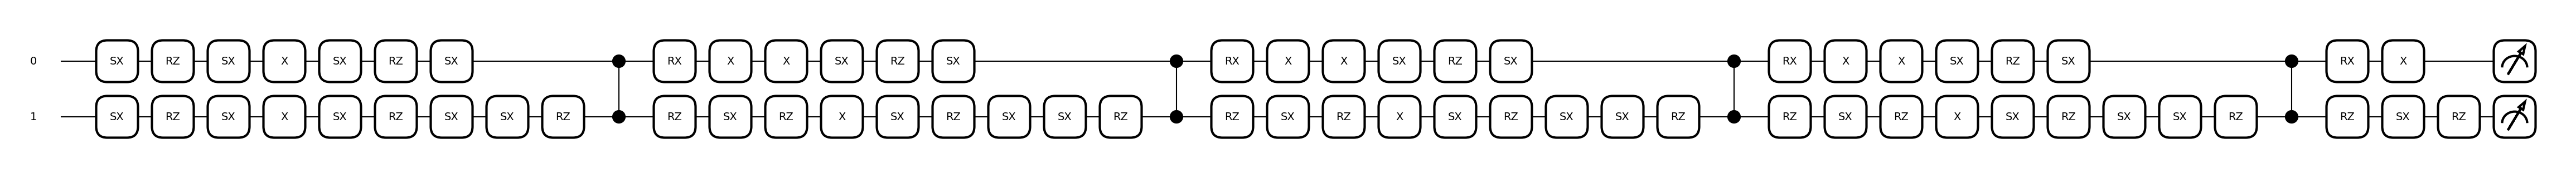

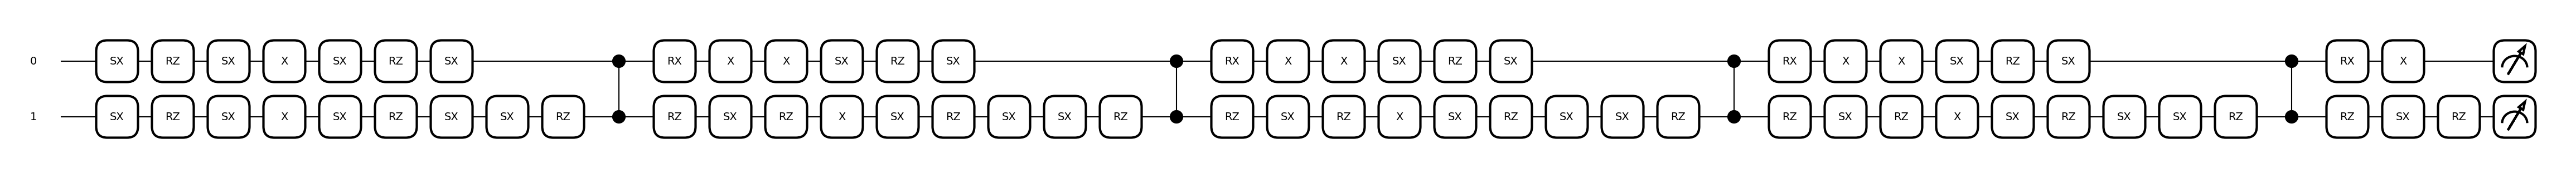

In [12]:
for circuit_num, params in enumerate(parameter_set):
    circuit.refresh()
    circuit.H(0)
    circuit.H(1)
    for i in range(len(params)//2):
        for j in range(num_qubits):
            circuit.RY(params[2*i+j], j)
        circuit.CY(0, 1)
    circuit.draw_circuit(style="mpl")
    probs_pure_list.append(circuit.run_pure_state(list(range(num_qubits))))
    probs_sim_list.append(circuit.execute(list(range(num_qubits))))
    hardware_runner.create_circuits(circuit=circuit, measure_qubits=list(range(num_qubits)))

## Setup the Circuits for Submission

In [13]:
hardware_runner.setup_circuits()

qiskit_runtime_service.backends:WARNING:2025-11-24 17:28:02,593: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-24 17:28:03,663: Using instance: Open_Sys, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-24 17:28:04,973: Using instance: Open_Sys, plan: open


## Submit the Circuits

In [14]:
job_id = hardware_runner.run()

qiskit_runtime_service.backends:WARNING:2025-11-24 17:28:08,602: Using instance: Open_Sys, plan: open


Job ID: d4i8f6ccdebc73f2qr30


# Query Job Status

In [15]:
hardware_runner.status()

'RUNNING'

## Job Cancellation

In the event the job hasn't already been completed, they can be cancelled.

In [ ]:
hardware_runner.cancel()

## Get Results

In [16]:
probs_hardware_list = hardware_runner.get_results()

## Compare Results

To compare the results we use the Battacharyya Coefficient defined for discrete probability distributions by:
\begin{equation}
BC(p, q) = \sum_{i=1}^N \sqrt{p_i q_i}
\end{equation}

In [17]:
def battacharyya_coefficient(p, q):
    return np.sum(np.sqrt(p * q))

In [18]:
for i in range(len(probs_pure_list)):
    print("Fidelity between Pure State Simulation and MCWF Simulation Results:\t", battacharyya_coefficient(probs_pure_list[i], probs_sim_list[i]))
    print("Fidelity between Pure State Simulation and Hardware Results:\t", battacharyya_coefficient(probs_pure_list[i], probs_hardware_list[i]))
    print("Fidelity between MCWF Simulation and Hardware Results:\t", battacharyya_coefficient(probs_sim_list[i], probs_hardware_list[i]))
    print("----------------------------------------------------------------------------------------------")

Fidelity between Pure State Simulation and MCWF Simulation Results:	 0.9990601457708641
Fidelity between Pure State Simulation and Hardware Results:	 0.9999794003649861
Fidelity between MCWF Simulation and Hardware Results:	 0.9991502453660175
----------------------------------------------------------------------------------------------
Fidelity between Pure State Simulation and MCWF Simulation Results:	 0.9998706676879365
Fidelity between Pure State Simulation and Hardware Results:	 0.9877721424774056
Fidelity between MCWF Simulation and Hardware Results:	 0.987522820023227
----------------------------------------------------------------------------------------------
Fidelity between Pure State Simulation and MCWF Simulation Results:	 0.9930360306266686
Fidelity between Pure State Simulation and Hardware Results:	 0.9925720758757046
Fidelity between MCWF Simulation and Hardware Results:	 0.9917765564379074
-------------------------------------------------------------------------------

## Shutdown Circuit

In [19]:
circuit.shutdown()